# Exploration and Comparison of Transformers for Image Classification

## Linear Probing using CLIP

Linear Probing is an experiment that involes training a linear classifier on top of pre-trained frozen features of the model.

In this experiment, the whole training set is used.

### CLIP (Contrastive Language-Image Pre-Training)

The CLIP model was proposed in *Learning Transferable Visual Models From Natural Language Supervision by Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever*. 

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

https://arxiv.org/abs/2103.0002030

Linear probing with CLIP is done by using its vision encoder with an image classification head on top (a linear layer on top of the pooled final hidden states of the patch tokens) e.g. for ImageNet.

https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPForImageClassification

### Prerequisites

Load necessary packages.

In [1]:
import os
os.chdir('../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [2]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [3]:
id = 10
torch.manual_seed(10)

Load CLIP image processor used for image pre-processing. Tokenizer is not needed as the text encoder part of the model is not used.

In [4]:
processor, _ = get_clip_processor_and_tokenizer()

Print the pre-processing operations done by the processor.

In [5]:
processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [6]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [7]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [8]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [9]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [10]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [11]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for experiments and print its settings.

In [2]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=1e-4,
    optimizer=AdamW,
    weight_decay=0
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.0001,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0}

Create empty array to store dataset accuracies for each experiment.

In [13]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Linear Probing


Train a new linear classifier on top of pre-trained model base.

#### RESISC45

In [14]:
clip_resisc45 = CLIP(for_training=True, num_classes=len(resisc45_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
get_model_params(clip_resisc45)

Parameters: 85.83M


In [16]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    clip_resisc45,
    resisc45_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 2363/2363 [03:40<00:00, 10.73it/s]


Epochs: 1/10 | train_loss: 2.3777 | train_acc: 0.6285


100%|██████████| 2363/2363 [03:40<00:00, 10.70it/s]


Epochs: 2/10 | train_loss: 1.1229 | train_acc: 0.8302


100%|██████████| 2363/2363 [03:40<00:00, 10.71it/s]


Epochs: 3/10 | train_loss: 0.7631 | train_acc: 0.8553


100%|██████████| 2363/2363 [03:39<00:00, 10.77it/s]


Epochs: 4/10 | train_loss: 0.6053 | train_acc: 0.8693


100%|██████████| 2363/2363 [03:38<00:00, 10.81it/s]


Epochs: 5/10 | train_loss: 0.5169 | train_acc: 0.8795


100%|██████████| 2363/2363 [03:39<00:00, 10.76it/s]


Epochs: 6/10 | train_loss: 0.4596 | train_acc: 0.8888


100%|██████████| 2363/2363 [03:37<00:00, 10.84it/s]


Epochs: 7/10 | train_loss: 0.4199 | train_acc: 0.8956


100%|██████████| 2363/2363 [03:38<00:00, 10.79it/s]


Epochs: 8/10 | train_loss: 0.3892 | train_acc: 0.9014


100%|██████████| 2363/2363 [03:39<00:00, 10.78it/s]


Epochs: 9/10 | train_loss: 0.3653 | train_acc: 0.9054


100%|██████████| 2363/2363 [03:40<00:00, 10.73it/s]

Epochs: 10/10 | train_loss: 0.3459 | train_acc: 0.9098


In [17]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    clip_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:12<00:00, 10.79it/s]

test_loss: 0.3766 | test_acc: 0.8987


In [18]:
resisc45_accs.append(resisc45_acc)

In [19]:
get_top_5_accuracies(resisc45_per_class_acc)

[('chaparral', 1.0),
 ('snowberg', 0.9874213836477987),
 ('beach', 0.9769230769230769),
 ('sea ice', 0.9668874172185431),
 ('harbor', 0.9647887323943662)]

In [20]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.6857142857142857),
 ('tennis court', 0.6875),
 ('railway station', 0.7532467532467533),
 ('freeway', 0.7966101694915254),
 ('basketball court', 0.8059701492537313)]

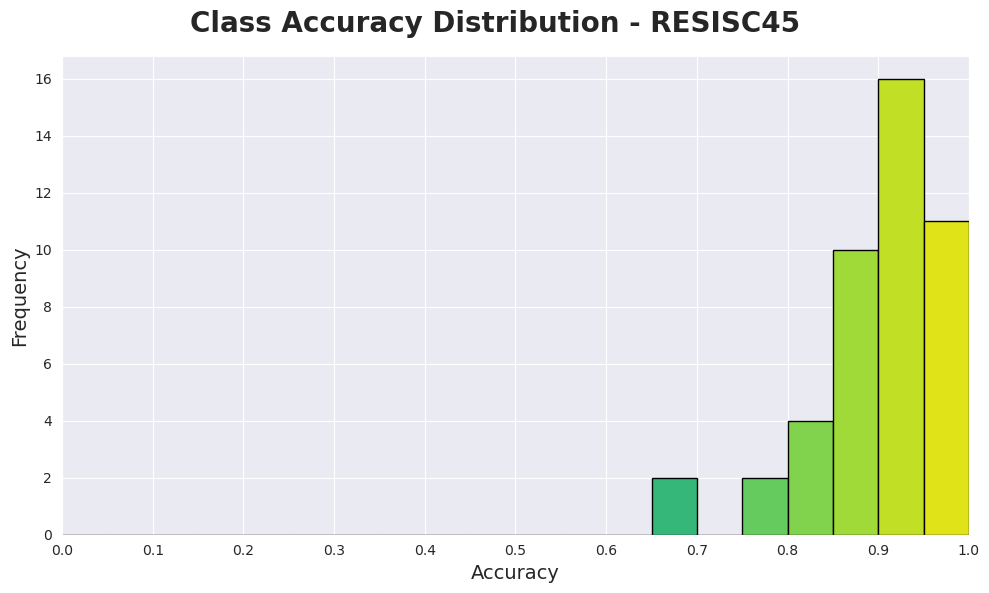

In [21]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [22]:
clip_food101 = CLIP(for_training=True, num_classes=len(food101_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
get_model_params(clip_food101)

Parameters: 85.88M


In [24]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    clip_food101,
    food101_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
)

 12%|█▏        | 1176/9469 [02:13<15:12,  9.09it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [17:24<00:00,  9.07it/s]


Epochs: 1/10 | train_loss: 2.4411 | train_acc: 0.6437


100%|██████████| 9469/9469 [17:23<00:00,  9.07it/s]


Epochs: 2/10 | train_loss: 1.1398 | train_acc: 0.7959


100%|██████████| 9469/9469 [17:22<00:00,  9.09it/s]


Epochs: 3/10 | train_loss: 0.8789 | train_acc: 0.8177


100%|██████████| 9469/9469 [17:25<00:00,  9.05it/s]


Epochs: 4/10 | train_loss: 0.7682 | train_acc: 0.8299


100%|██████████| 9469/9469 [17:22<00:00,  9.08it/s]


Epochs: 5/10 | train_loss: 0.7043 | train_acc: 0.8385


100%|██████████| 9469/9469 [17:17<00:00,  9.12it/s]


Epochs: 6/10 | train_loss: 0.6625 | train_acc: 0.8452


100%|██████████| 9469/9469 [17:21<00:00,  9.09it/s]


Epochs: 7/10 | train_loss: 0.6320 | train_acc: 0.8499


100%|██████████| 9469/9469 [17:20<00:00,  9.10it/s]


Epochs: 8/10 | train_loss: 0.6078 | train_acc: 0.8540


100%|██████████| 9469/9469 [17:22<00:00,  9.08it/s]


Epochs: 9/10 | train_loss: 0.5890 | train_acc: 0.8580


100%|██████████| 9469/9469 [17:22<00:00,  9.09it/s]


Epochs: 10/10 | train_loss: 0.5728 | train_acc: 0.8604


In [25]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    clip_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:49<00:00,  9.04it/s]


test_loss: 0.4460 | test_acc: 0.8891


In [26]:
food101_accs.append(food101_acc)

In [27]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.996),
 ('macarons', 0.984),
 ('eggs benedict', 0.976),
 ('french fries', 0.976),
 ('oysters', 0.976)]

In [28]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.564),
 ('tuna tartare', 0.62),
 ('foie gras', 0.696),
 ('pork chop', 0.712),
 ('chocolate mousse', 0.716)]

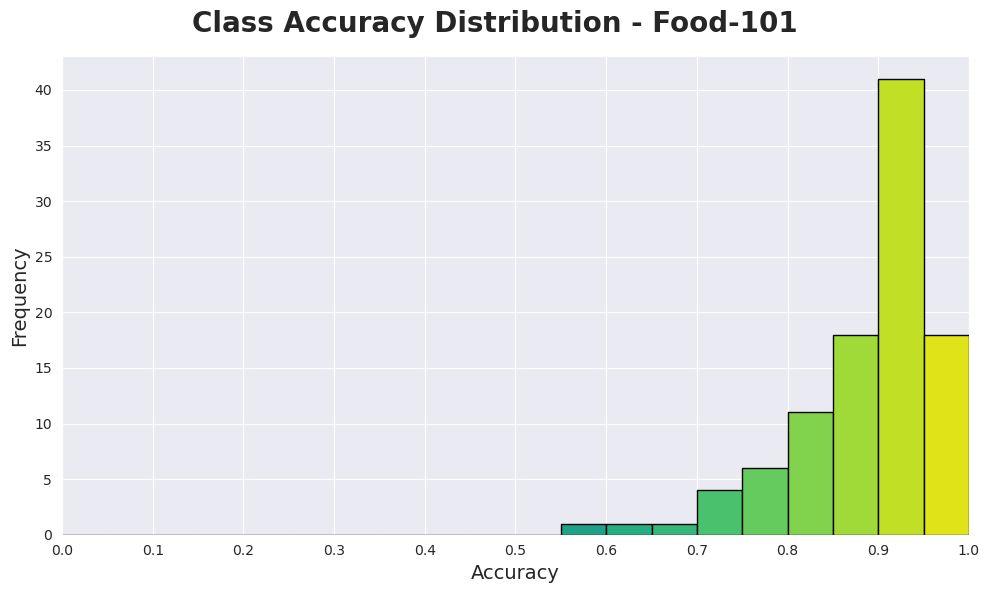

In [29]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [30]:
clip_fer2013 = CLIP(for_training=True, num_classes=len(fer2013_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
get_model_params(clip_fer2013)

Parameters: 85.80M


In [32]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    clip_fer2013,
    fer2013_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 3589/3589 [05:12<00:00, 11.48it/s]


Epochs: 1/10 | train_loss: 1.4292 | train_acc: 0.4966


100%|██████████| 3589/3589 [05:11<00:00, 11.51it/s]


Epochs: 2/10 | train_loss: 1.1271 | train_acc: 0.6163


100%|██████████| 3589/3589 [05:11<00:00, 11.52it/s]


Epochs: 3/10 | train_loss: 1.0315 | train_acc: 0.6376


100%|██████████| 3589/3589 [05:11<00:00, 11.52it/s]


Epochs: 4/10 | train_loss: 0.9840 | train_acc: 0.6497


100%|██████████| 3589/3589 [05:11<00:00, 11.51it/s]


Epochs: 5/10 | train_loss: 0.9555 | train_acc: 0.6582


100%|██████████| 3589/3589 [05:11<00:00, 11.51it/s]


Epochs: 6/10 | train_loss: 0.9360 | train_acc: 0.6612


100%|██████████| 3589/3589 [05:11<00:00, 11.51it/s]


Epochs: 7/10 | train_loss: 0.9213 | train_acc: 0.6663


100%|██████████| 3589/3589 [05:10<00:00, 11.54it/s]


Epochs: 8/10 | train_loss: 0.9101 | train_acc: 0.6688


100%|██████████| 3589/3589 [05:12<00:00, 11.49it/s]


Epochs: 9/10 | train_loss: 0.9013 | train_acc: 0.6718


100%|██████████| 3589/3589 [05:11<00:00, 11.52it/s]

Epochs: 10/10 | train_loss: 0.8941 | train_acc: 0.6737


In [33]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    clip_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:38<00:00, 11.55it/s]

test_loss: 0.9149 | test_acc: 0.6709


In [34]:
fer2013_accs.append(fer2013_acc)

In [35]:
fer2013_per_class_acc

{'angry': 0.6191446028513238,
 'disgust': 0.18181818181818182,
 'fear': 0.29924242424242425,
 'happy': 0.8976109215017065,
 'sad': 0.6245791245791246,
 'surprise': 0.7620192307692307,
 'neutral': 0.7332268370607029}

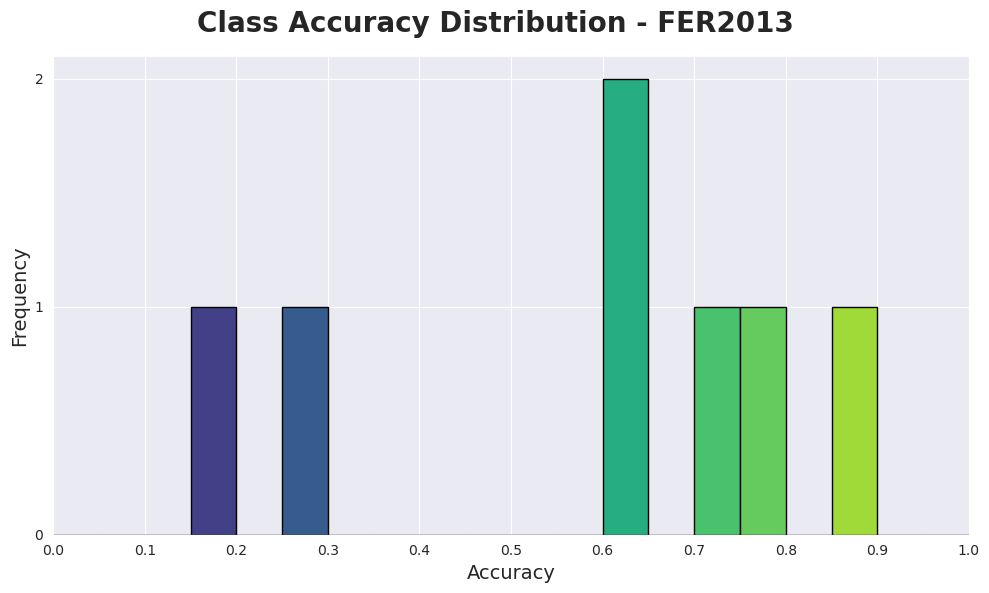

In [36]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [37]:
clip_pcam = CLIP(for_training=True, num_classes=len(pcam_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
get_model_params(clip_pcam)

Parameters: 85.80M


In [39]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    clip_pcam,
    pcam_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 32768/32768 [48:01<00:00, 11.37it/s]


Epochs: 1/10 | train_loss: 0.3743 | train_acc: 0.8353


100%|██████████| 32768/32768 [47:58<00:00, 11.39it/s]


Epochs: 2/10 | train_loss: 0.3308 | train_acc: 0.8562


100%|██████████| 32768/32768 [47:58<00:00, 11.38it/s]


Epochs: 3/10 | train_loss: 0.3200 | train_acc: 0.8620


100%|██████████| 32768/32768 [47:57<00:00, 11.39it/s]


Epochs: 4/10 | train_loss: 0.3135 | train_acc: 0.8652


100%|██████████| 32768/32768 [48:01<00:00, 11.37it/s]


Epochs: 5/10 | train_loss: 0.3089 | train_acc: 0.8679


100%|██████████| 32768/32768 [47:57<00:00, 11.39it/s]


Epochs: 6/10 | train_loss: 0.3055 | train_acc: 0.8701


100%|██████████| 32768/32768 [47:56<00:00, 11.39it/s]


Epochs: 7/10 | train_loss: 0.3027 | train_acc: 0.8713


100%|██████████| 32768/32768 [47:55<00:00, 11.40it/s]


Epochs: 8/10 | train_loss: 0.3003 | train_acc: 0.8727


100%|██████████| 32768/32768 [47:55<00:00, 11.39it/s]


Epochs: 9/10 | train_loss: 0.2985 | train_acc: 0.8737


100%|██████████| 32768/32768 [47:56<00:00, 11.39it/s]


Epochs: 10/10 | train_loss: 0.2969 | train_acc: 0.8749


In [40]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    clip_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:59<00:00, 11.41it/s]

test_loss: 0.3603 | test_acc: 0.8364


In [41]:
pcam_accs.append(pcam_acc)

In [42]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.8786529192849735,
 'lymph node tumor tissue': 0.7940404225438115}

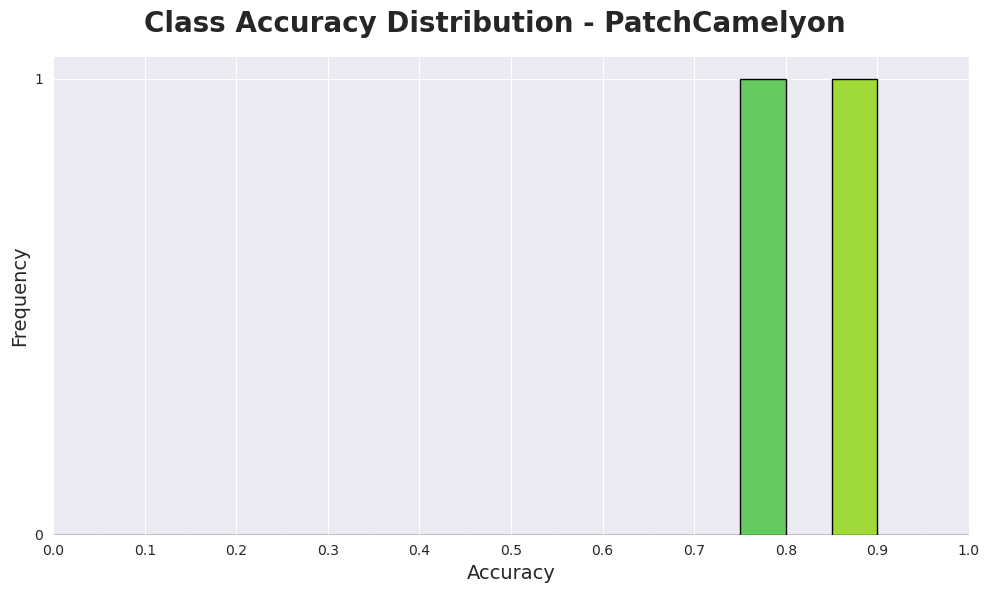

In [43]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [44]:
clip_sun397 = CLIP(for_training=True, num_classes=len(sun397_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
get_model_params(clip_sun397)

Parameters: 86.10M


In [46]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    clip_sun397,
    sun397_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 9516/9516 [18:17<00:00,  8.67it/s]


Epochs: 1/10 | train_loss: 3.4300 | train_acc: 0.4205


100%|██████████| 9516/9516 [18:02<00:00,  8.79it/s]


Epochs: 2/10 | train_loss: 1.6271 | train_acc: 0.6819


100%|██████████| 9516/9516 [18:01<00:00,  8.80it/s]


Epochs: 3/10 | train_loss: 1.1757 | train_acc: 0.7420


100%|██████████| 9516/9516 [18:02<00:00,  8.79it/s]


Epochs: 4/10 | train_loss: 0.9887 | train_acc: 0.7668


100%|██████████| 9516/9516 [18:02<00:00,  8.79it/s]


Epochs: 5/10 | train_loss: 0.8865 | train_acc: 0.7812


100%|██████████| 9516/9516 [18:03<00:00,  8.78it/s]


Epochs: 6/10 | train_loss: 0.8201 | train_acc: 0.7912


100%|██████████| 9516/9516 [18:02<00:00,  8.79it/s]


Epochs: 7/10 | train_loss: 0.7718 | train_acc: 0.8010


100%|██████████| 9516/9516 [18:03<00:00,  8.78it/s]


Epochs: 8/10 | train_loss: 0.7348 | train_acc: 0.8074


100%|██████████| 9516/9516 [18:03<00:00,  8.79it/s]


Epochs: 9/10 | train_loss: 0.7048 | train_acc: 0.8122


100%|██████████| 9516/9516 [18:03<00:00,  8.78it/s]


Epochs: 10/10 | train_loss: 0.6803 | train_acc: 0.8189


In [47]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    clip_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [05:11<00:00,  8.72it/s]


test_loss: 0.7722 | test_acc: 0.7906


In [48]:
sun397_accs.append(sun397_acc)

In [49]:
get_top_5_accuracies(sun397_per_class_acc)

[('arrival gate (outdoor)', 1.0),
 ('auto factory', 1.0),
 ('ball pit', 1.0),
 ('batters box', 1.0),
 ('desert (sand)', 1.0)]

In [50]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('recreation room', 0.07407407407407407),
 ('fairway', 0.0851063829787234),
 ('bistro (indoor)', 0.10526315789473684),
 ('courtyard', 0.125),
 ('library (outdoor)', 0.14285714285714285)]

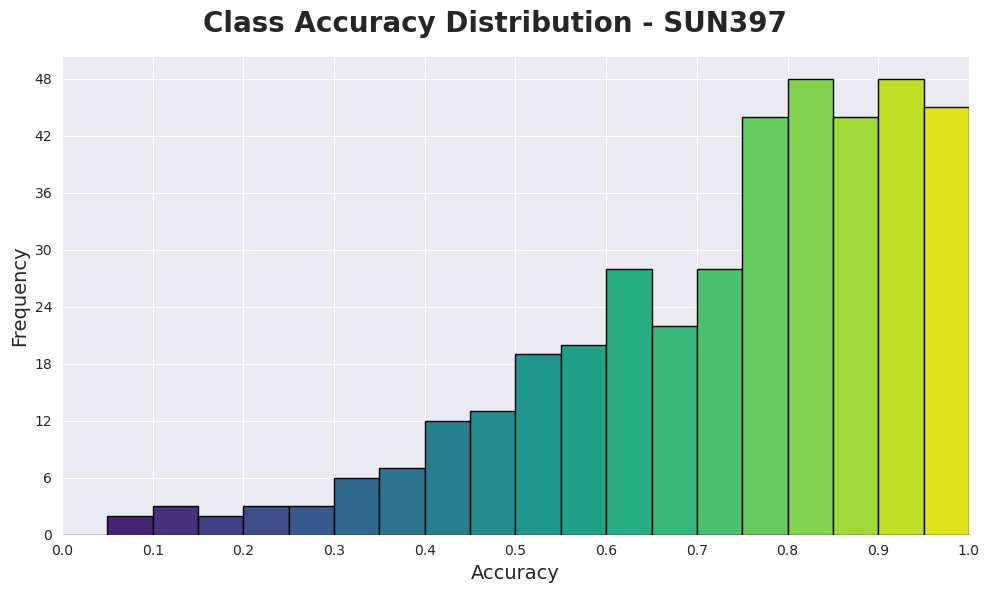

In [51]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [52]:
clip_dtd = CLIP(for_training=True, num_classes=len(dtd_train.get_labels()))

Some weights of CLIPForImageClassification were not initialized from the model checkpoint at openai/clip-vit-base-patch16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
get_model_params(clip_dtd)

Parameters: 85.84M


In [54]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    clip_dtd,
    dtd_train,
    config,
    'clip',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 470/470 [00:54<00:00,  8.70it/s]


Epochs: 1/10 | train_loss: 3.6095 | train_acc: 0.2056


100%|██████████| 470/470 [00:53<00:00,  8.78it/s]


Epochs: 2/10 | train_loss: 3.0049 | train_acc: 0.5726


100%|██████████| 470/470 [00:53<00:00,  8.80it/s]


Epochs: 3/10 | train_loss: 2.5244 | train_acc: 0.6628


100%|██████████| 470/470 [00:53<00:00,  8.73it/s]


Epochs: 4/10 | train_loss: 2.1593 | train_acc: 0.7059


100%|██████████| 470/470 [00:53<00:00,  8.73it/s]


Epochs: 5/10 | train_loss: 1.8855 | train_acc: 0.7237


100%|██████████| 470/470 [00:53<00:00,  8.74it/s]


Epochs: 6/10 | train_loss: 1.6779 | train_acc: 0.7388


100%|██████████| 470/470 [00:53<00:00,  8.72it/s]


Epochs: 7/10 | train_loss: 1.5158 | train_acc: 0.7495


100%|██████████| 470/470 [00:53<00:00,  8.73it/s]


Epochs: 8/10 | train_loss: 1.3886 | train_acc: 0.7582


100%|██████████| 470/470 [00:53<00:00,  8.74it/s]


Epochs: 9/10 | train_loss: 1.2841 | train_acc: 0.7641


100%|██████████| 470/470 [00:53<00:00,  8.74it/s]

Epochs: 10/10 | train_loss: 1.1986 | train_acc: 0.7699


In [55]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    clip_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:26<00:00,  8.89it/s]

test_loss: 1.2674 | test_acc: 0.7261


In [56]:
dtd_accs.append(dtd_acc)

In [57]:
get_top_5_accuracies(dtd_per_class_acc)

[('bubbly', 0.975),
 ('crystalline', 0.975),
 ('knitted', 0.975),
 ('paisley', 0.95),
 ('zigzagged', 0.95)]

In [58]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('pitted', 0.175),
 ('blotchy', 0.225),
 ('woven', 0.4),
 ('grid', 0.45),
 ('stained', 0.45)]

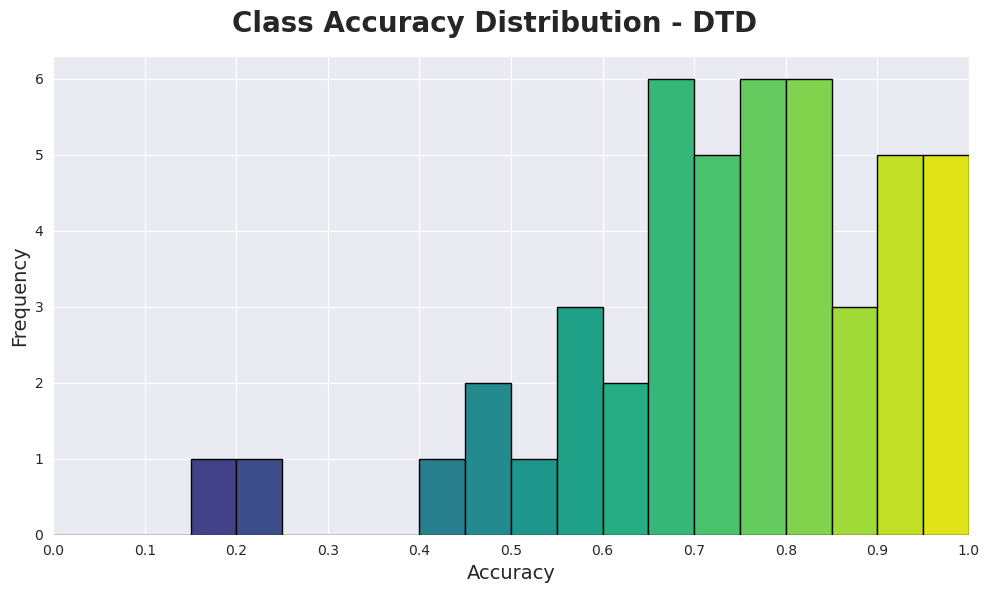

In [59]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [60]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [61]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [62]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [63]:
df = pd.DataFrame(results, columns=['linear probe'], index=labels)
df

,linear probe
RESISC45,0.898730
Food-101,0.889149
FER2013,0.670939
PatchCamelyon,0.836365
SUN397,0.790575
DTD,0.726064
